# KNN su Arcehtipi Pokémon — 10-Fold Cross-Validation (k vs. errore)

Questo notebook esegue una validazione incrociata a 10 fold per **K-Nearest Neighbors**,
tracciando **k (iper-paramentro vs. errore di validazione**.
**Nota:** si assume di avere un file `risorse/training_bilanciato.csv` con le colonne:

- `OFF_FISICO`, `OFF_SPECIALE`, `TANK_FISICO`, `TANK_SPECIALE` (feature numeriche)
- `Archetipo` (target)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score

In [2]:
TRAINING_PATH = "risorse/training_bilanciato.csv"
TEST_PATH     = "risorse/test_set.csv"
FEATURES = ["OFF_FISICO", "OFF_SPECIALE", "TANK_FISICO", "TANK_SPECIALE"]
TARGET   = "Archetipo"

df_train = pd.read_csv(TRAINING_PATH)
df_test  = pd.read_csv(TEST_PATH)

# Controllo colonne
missing_train = [c for c in FEATURES + [TARGET] if c not in df_train.columns]
missing_test  = [c for c in FEATURES + [TARGET] if c not in df_test.columns]
if missing_train:
    raise KeyError(f"Mancano colonne nel TRAINING SET: {missing_train}")
if missing_test:
    raise KeyError(f"Mancano colonne nel TEST SET: {missing_test}")

# Selezione e copia
df_train = df_train[FEATURES + [TARGET]].copy()
df_test  = df_test[FEATURES + [TARGET]].copy()

# Conversione a numerico
for c in FEATURES:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")
    df_test[c]  = pd.to_numeric(df_test[c],  errors="coerce")

# Drop NaN (train e test)
before = len(df_train)
df_train = df_train.dropna(subset=FEATURES + [TARGET])
after = len(df_train)
if after < before:
    print(f"Attenzione: rimosse {before - after} righe (NaN) dal TRAINING.")

before_t = len(df_test)
df_test  = df_test.dropna(subset=FEATURES + [TARGET])
after_t  = len(df_test)
if after_t < before_t:
    print(f"Attenzione: rimosse {before_t - after_t} righe (NaN) dal TEST.")

# Distribuzioni classi
print("Distribuzione classi del TRAINING SET (y_train):")
x_train = df_train[FEATURES].to_numpy()
y_train = df_train[TARGET].to_numpy()
print(pd.Series(y_train).value_counts(normalize=True).round(2))
print(pd.Series(y_train).value_counts())

print("\nDistribuzione classi del TEST SET (y_test):")
x_test = df_test[FEATURES].to_numpy()
y_test = df_test[TARGET].to_numpy()
print(pd.Series(y_test).value_counts(normalize=True).round(2))
print(pd.Series(y_test).value_counts())

Distribuzione classi del TRAINING SET (y_train):
Balanced             0.25
Attaccante           0.25
Tank                 0.25
Elite/Leggendario    0.25
Name: proportion, dtype: float64
Balanced             245
Attaccante           245
Tank                 245
Elite/Leggendario    245
Name: count, dtype: int64

Distribuzione classi del TEST SET (y_test):
Attaccante           0.36
Balanced             0.31
Tank                 0.22
Elite/Leggendario    0.11
Name: proportion, dtype: float64
Attaccante           54
Balanced             47
Tank                 33
Elite/Leggendario    17
Name: count, dtype: int64


### Valutazione tramite Cross-Validation (KNN)

In questa sezione viene eseguita una **valutazione comparativa del classificatore K-Nearest Neighbors** su una griglia di valori dispari di `k` compresi tra 1 e 29.
La valutazione è basata su una **10-fold Stratified Cross-Validation**, che garantisce la **preservazione della distribuzione delle classi** in ciascun fold.

Per ogni valore di `k`, si calcolano:

*  **Accuracy**
* **Precision (macro)**
* **Recall (macro)**
* **F1-score (macro)**

> L'uso della media **macro** assicura che ciascuna classe abbia lo stesso peso, rendendo il confronto robusto anche in presenza di sbilanciamento tra le classi.

Per ciascuna metrica, vengono salvate:
* la **media** tra i 10 fold (valutazione centrale delle performance)
* la **deviazione standard** (stima della **variabilità** dei risultati, quindi della **stabilità del modello** rispetto alla partizione dei dati)

Infine:
* Viene mostrata una **tabella ordinata per F1-score**, utile per individuare il valore di `k` più promettente.
* Viene visualizzata una **tabella riassuntiva** con la **media ± deviazione standard** delle metriche su **tutti i valori di `k` testati**.

Questo approccio consente un'**analisi quantitativa accurata** per la scelta dell'iperparametro `k` e una **valutazione attendibile** delle performance attese del modello.

In [3]:
# === Setup grid e scoring ===
k_grid = list(range(1, 31, 2))  # k dispari da 1 a 29
"""
Questa strategia stratificata è fortemente consigliata per classificazione, soprattutto se:
- il dataset è sbilanciato
- stai usando metriche macro
- vuoi ottenere valutazioni più stabili e affidabili"""
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

cv_rows = []

# === Ciclo su k ===
for k in k_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)),
    ])
    scores = cross_validate(pipe, x_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

    # Aggiungi media e std di tutte le metriche
    cv_rows.append({
        "k": k,
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std":  scores["test_accuracy"].std(),

        "prec_mean": scores["test_precision_macro"].mean(),
        "prec_std":  scores["test_precision_macro"].std(),

        "rec_mean": scores["test_recall_macro"].mean(),
        "rec_std":  scores["test_recall_macro"].std(),

        "f1_mean": scores["test_f1_macro"].mean(),
        "f1_std":  scores["test_f1_macro"].std(),
    })

# === Tabella finale ===
cv_table = pd.DataFrame(cv_rows).sort_values("k").reset_index(drop=True)

#  Top-10 per F1-score
top10_f1 = cv_table.sort_values("f1_mean", ascending=False).reset_index(drop=True)
print("Top-10 per F1-macro in CV:")
display(top10_f1.style.hide(axis="index"))

# Media globale delle metriche su tutti i k testati
global_stats = {
    "Accuracy": f"{cv_table['acc_mean'].mean():.3f} ± {cv_table['acc_std'].mean():.3f}",
    "Precisione": f"{cv_table['prec_mean'].mean():.3f} ± {cv_table['prec_std'].mean():.3f}",
    "Richiamo": f"{cv_table['rec_mean'].mean():.3f} ± {cv_table['rec_std'].mean():.3f}",
    "F1-score": f"{cv_table['f1_mean'].mean():.3f} ± {cv_table['f1_std'].mean():.3f}",
}

# Tabella con valori "metric ± std"
df_global = pd.DataFrame(global_stats, index=["Media ± std su tutti i k"])
display(df_global)

Top-10 per F1-macro in CV:


k,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std
1,0.975510,0.016580,0.976629,0.015843,0.975375,0.016586,0.975393,0.016621
3,0.972449,0.018843,0.973813,0.017991,0.972375,0.018709,0.972242,0.018840
15,0.971429,0.009998,0.972443,0.009629,0.971500,0.010037,0.971430,0.009977
5,0.971429,0.017556,0.972727,0.016461,0.971458,0.017611,0.971305,0.017595
17,0.970408,0.009627,0.971304,0.009426,0.970458,0.009681,0.970430,0.009658
13,0.970408,0.013265,0.971877,0.012282,0.970417,0.013405,0.970318,0.013311
21,0.969388,0.014431,0.970271,0.014097,0.969458,0.014447,0.969338,0.014469
23,0.969388,0.013690,0.970097,0.013220,0.969500,0.013704,0.969323,0.013714
11,0.968367,0.013265,0.969751,0.012581,0.968333,0.013340,0.968262,0.013251
9,0.968367,0.014028,0.969625,0.013390,0.968375,0.014132,0.968226,0.014185


,Accuracy,Precisione,Richiamo,F1-score
Media ± std su tutti i k,0.969 ± 0.014,0.970 ± 0.014,0.969 ± 0.014,0.969 ± 0.014


La deviazione standard osservata tra le dieci fold di validazione incrociata risulta estremamente contenuta (±0.01), a indicare un'elevata stabilità del modello e una scarsa dipendenza dalla specifica partizione dei dati.

### Analisi dell’Errore Medio in Cross-Validation con Deviazione Standard

Nel grafico riportato viene visualizzato l’**errore medio in validazione (1 - F1 Macro)** ottenuto tramite una **10-Fold Stratified Cross-Validation**, al variare del parametro `k` nel classificatore KNN.

Per ciascun valore dispari di `k` nel range [1, 29], sono state calcolate:
- La **media** della F1 Macro score sulle 10 fold
- La **deviazione standard**, per valutare la **stabilità** delle performance

Le **barre verticali** rappresentano la deviazione standard attorno all’errore medio, ovvero l’intervallo di fluttuazione dei risultati. Ciò consente di identificare non solo il valore di `k` con la performance media migliore, ma anche quello che offre maggiore **robustezza e coerenza** tra le fold.
Nel grafico seguente, rappresentiamo l'errore medio in validazione incrociata (definito come `1 - F1_macro`) in funzione del numero di vicini `k` utilizzati nel classificatore KNN.
La deviazione standard riportata è calcolata direttamente sui valori di F1 ottenuti nei 10 fold della cross-validation.
Poiché la deviazione standard è invariante rispetto a trasformazioni lineari come `1 - x`, essa rimane valida anche quando si rappresenta l’errore (`1 - F1`), e può quindi essere plottata in modo coerente come intervallo di incertezza intorno al valore medio dell’errore.

Questo grafico consente di individuare visivamente il valore di `k` che ottimizza le prestazioni del modello, tenendo conto anche della stabilità (variazione) dei risultati nei diversi fold.

> Un valore di `k` con **basso errore medio** e **deviazione standard contenuta** rappresenta la scelta ottimale per il modello, in quanto bilancia efficacia e stabilità.


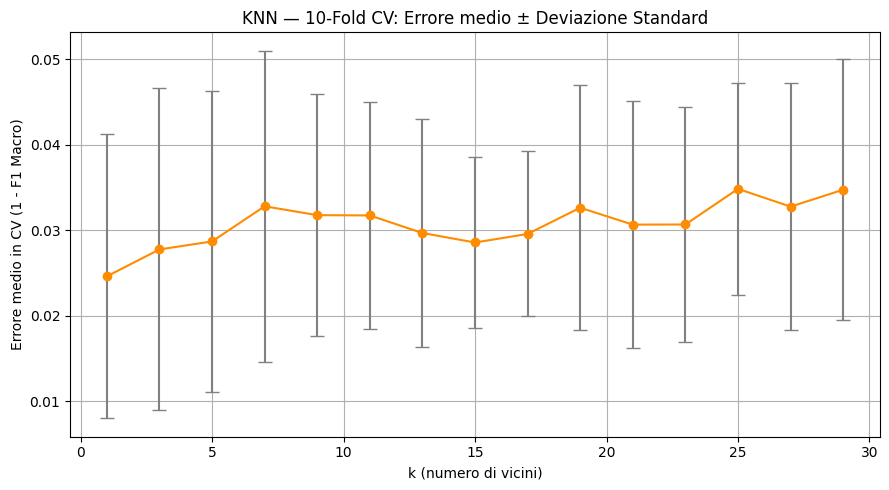

In [4]:
# === Analisi finale: errore medio e selezione best_k ===
k_values = cv_table["k"]
mean_f1_errors = 1 - cv_table["f1_mean"]
std_f1_errors  = cv_table["f1_std"]  # deviazione standard su F1

plt.figure(figsize=(9, 5))
plt.errorbar(k_values, mean_f1_errors, yerr=std_f1_errors,
             fmt='-o', capsize=5, color='darkorange', ecolor='gray')

plt.xlabel("k (numero di vicini)")
plt.ylabel("Errore medio in CV (1 - F1 Macro)")
plt.title("KNN — 10-Fold CV: Errore medio ± Deviazione Standard")
plt.grid(True)
plt.tight_layout()
plt.show()

### Valutazione finale sul Test Set (modello supervisionato KNN)

In questa fase si esegue il **fit finale del modello KNN** sul training set bilanciato (`X`, `y`) utilizzando il valore di `k` selezionato precedentemente
Il pipeline include:
- **StandardScaler** per la normalizzazione delle feature;
- **KNeighborsClassifier** con distanza Euclidea (`p=2`).

Successivamente, si procede a:
1. Caricare il `test_set.csv` (creato in precedenza);
2. Applicare lo stesso preprocessing (conversione numerica delle feature);
3. Calcolare le predizioni `y_pred` sul test set;
4. Stampare la distribuzione delle classi di `y_test` per confronto.

Questa valutazione rappresenta la **performance finale del modello supervisionato**, da confrontare con altri modelli (es. Dummy Classifier ecc.) mantenendo **invariato il test set**, per evitare fenomeni di **data leakage**.

In [5]:
# Fit finale sul train bilanciato con k scelto ===
best_k = 13
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors = best_k))
])

pipe_final.fit(x_train, y_train)
#modello finale
y_pred = pipe_final.predict(x_test)

#### Calcolo delle metriche del modello appreso validato su test set
Nota bene il momento in cui effettuiamo la valutazione sul test set. SOLO dopo aver utilizzato la 10 fold cross validation abbiamo scelto il modello con l'iperparametro migliore e lo abbiamo addestrato nuovamente
sui dati di traning. Questo modello infine, viene valutato sul test set che prima di adesso non abbiamo mai toccato.

=== Metriche su TEST (k=13) ===
Accuracy : 0.9073
Precision: 0.9077 (macro)
Recall   : 0.9074 (macro)
F1-score : 0.9074 (macro)


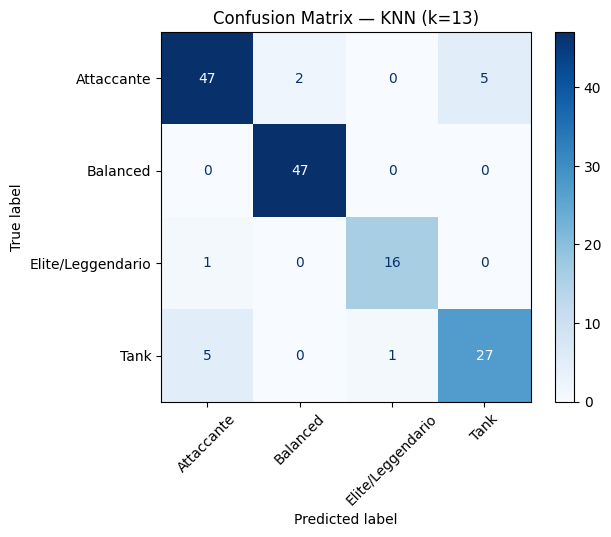

In [6]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"=== Metriche su TEST (k={best_k}) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print(f"F1-score : {f1:.4f} (macro)")

# === 4) Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title(f"Confusion Matrix — KNN (k={best_k})")
plt.show()

Il confronto tra KNN addestrato su training set bilanciato (con SMOTE) e non bilanciato ha mostrato che, a parità di valore di `best_k`, il bilanciamento produce un modello complessivamente più equo e robusto. Pur mantenendo un'ottima accuratezza in entrambi i casi, il modello bilanciato migliora in modo significativo il **recall e F1-score**, in particolare per le classi meno rappresentate come "Tank" ed "Elite/Leggendario". Questo risultato suggerisce che, sebbene l'accuracy possa rimanere elevata anche con un dataset sbilanciato, metriche più sensibili alla distribuzione delle classi (come F1 macro) evidenziano l'importanza di un training bilanciato.

Nel caso bilanciato, si è scelto un valore intermedio per il modello KNN. Tale valore rappresenta un buon compromesso tra stabilità e capacità discriminativa, evitando sia l'overfitting (tipico di k troppo piccoli) che l'underfitting (tipico di k troppo grandi). La scelta è stata guidata minimizzando l'errore medio in cross-validation rispetto alla F1-score macro, metrica più adatta in presenza di classi bilanciate.



## Confronto tra Decision Tree e K-Nearest Neighbors (KNN)

Dai risultati sperimentali emerge che il classificatore **KNN** ha ottenuto performance superiori rispetto al modello ad **albero di decisione**.
Questa differenza è spiegabile analizzando la natura dei dati e il principio di funzionamento dei due algoritmi:

- **KNN** classifica un esempio sulla base della **distanza euclidea** dai vicini più prossimi.
  Nel nostro caso, le classi (*Attaccante, Balanced, Tank, Elite/Leggendario*) derivano da **raggruppamenti naturali di statistiche combattive** (OFF_FISICO, OFF_SPECIALE, TANK_FISICO, TANK_SPECIALE).
  Tali raggruppamenti corrispondono a veri e propri **cluster nello spazio euclideo**, già evidenziati con l’analisi di K-Means.
  Per questo motivo, KNN riesce a sfruttare meglio la struttura intrinseca dei dati e a classificare in maniera più accurata.

- **Decision Tree**, al contrario, separa lo spazio delle feature tramite **soglie assiali** (ad esempio *OFF_FISICO > 80*).
  Questo approccio funziona bene se i confini tra le classi sono netti e facilmente esprimibili come regole, ma risulta meno adatto in un dominio come quello Pokémon, dove i valori numerici delle statistiche tendono a **sovrapporsi** tra classi diverse.
  In altre parole, **è difficile classificare i Pokémon esclusivamente sulla base di soglie numeriche rigide**, perché due classi differenti possono avere valori simili in più dimensioni, generando confusione.

### Conclusione
In questo scenario, **KNN risulta più adatto** a catturare la natura clusterizzata delle classi Pokémon, mentre l’albero di decisione resta uno strumento prezioso per l’**interpretabilità** delle decisioni e l’identificazione delle feature più discriminanti.
